# Problem Statement # 

Home appraisers predict real estate prices for lenders and buyers using machine learning algorithms such as linear regression models. And the success of these models will be evaluated using the cross-validation scores, in other words, R2 scores. The higher the R2 scores, the better the model fits the linear regression, making the predictions more likely to be true. The appraisal process is crucial to lenders, so you don't lend more money than the house is worth. The appraisal process is also important to home buyers, so you know if you overpaid for the property, and if you did, you can try to make up that loss during resale. 
For this project, we aim to build a linear regression model using specific features from the Ames IA dataset to predict housing prices. 

# Data Cleaning and EDA # 


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [2]:
# Import train data set 
house = pd.read_csv('Original data/train.csv')
house.head() 

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# Edit the column names so easier to read
house.columns = [column.replace(' ', '_').lower() for column in house.columns]

In [4]:
# Check for missing values
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

In [5]:
# Drop columns with more than 80% missing values 
# source: https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8
# ' When column has more than 80% to 95% missing value, drop it.'
twenty_percent = 2051 * 0.2 # If the column has less than twenty_percent non-null values, drop the whole column
twenty_percent 

410.20000000000005

In [6]:
# Drop the columns with less than 410 non-null values. 
house.drop(['alley', 'pool_qc', 'fence', 'misc_feature'], axis=1, inplace=True)

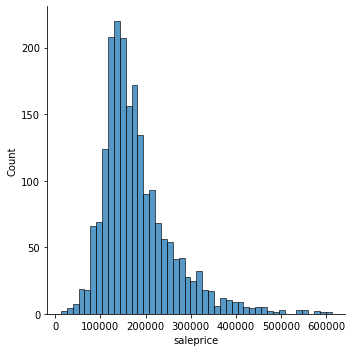

In [7]:
# Is sale price distributed normally?
sns.displot(data=house['saleprice'])
# The sale price is normally distributed, and skewed to the right
plt.tight_layout()
plt.savefig("Figures/sale_price_skewed.png")

In [8]:
# Removes outliers
def remove_outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]
    return df_out

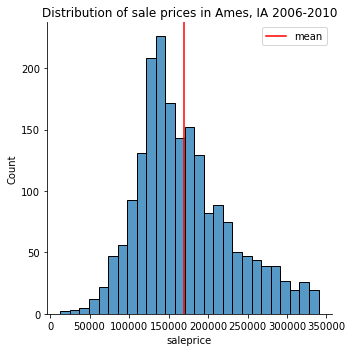

In [9]:
# Remove outliers in the 'saleprice', and plot the distribution
house = remove_outlier(house, 'saleprice')
sns.displot(house['saleprice']).set(title='Distribution of sale prices in Ames, IA 2006-2010')
plt.axvline(x=house['saleprice'].mean(), color='red', label='mean',)
plt.legend()
# The new distribution is more normally distributed, and not as skewed as the previous plot. 
plt.tight_layout()
plt.savefig("Figures/displot_saleprice.png")

In [10]:
# Look at the summary statistics of the whole dataset
house.describe()

,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
count,1957.000000,1.957000e+03,1957.000000,1629.000000,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000,1937.000000,...,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000,1957.000000
mean,1477.393459,7.199474e+08,57.652018,67.893186,9832.811957,5.983648,5.582524,1970.265713,1983.224323,83.997935,...,88.678590,45.407256,23.136944,2.482371,15.590189,2.513030,54.051610,6.203883,2007.783853,170140.600409
std,846.458057,1.886497e+08,43.286131,22.751075,6583.868565,1.319098,1.119159,29.976318,21.026185,151.539422,...,124.406088,65.979091,60.382376,24.673560,55.736128,38.676037,586.896066,2.745479,1.316012,59802.332903
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,754.000000,5.313760e+08,20.000000,57.000000,7415.000000,5.000000,5.000000,1952.000000,1963.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,128500.000000
50%,1481.000000,9.021000e+08,50.000000,67.000000,9248.000000,6.000000,5.000000,1972.000000,1991.000000,0.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,158500.000000
75%,2199.000000,9.071921e+08,70.000000,80.000000,11120.000000,7.000000,6.000000,1999.000000,2003.000000,135.000000,...,160.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,204500.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,340000.000000


#### - The null model, or baseline model is the mean sale price, which is \\$170140.

In [11]:
# Check the correlations of each column to saleprice
corr = house.corr()['saleprice'].sort_values(ascending=False).head(11)
corr

saleprice         1.000000
overall_qual      0.785928
gr_liv_area       0.652235
garage_cars       0.625719
garage_area       0.609726
year_built        0.600397
year_remod/add    0.572956
full_bath         0.555874
total_bsmt_sf     0.550446
garage_yr_blt     0.545975
1st_flr_sf        0.535557
Name: saleprice, dtype: float64

In [12]:
corr = house.corr()[['saleprice']].sort_values(by=['saleprice']).tail(11)
corr 

,saleprice
1st_flr_sf,0.535557
garage_yr_blt,0.545975
total_bsmt_sf,0.550446
full_bath,0.555874
year_remod/add,0.572956
year_built,0.600397
garage_area,0.609726
garage_cars,0.625719
gr_liv_area,0.652235
overall_qual,0.785928


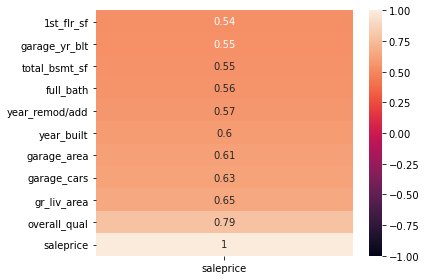

In [13]:
# Heatmap for visualization
sns.heatmap(corr, annot=True, vmax=1, vmin=-1)
plt.tight_layout()
plt.savefig("Figures/Heatmap.png")

In [14]:
house.corr()['saleprice'].sort_values(ascending=True).head(20)

pid               -0.211452
enclosed_porch    -0.144906
kitchen_abvgr     -0.130651
low_qual_fin_sf   -0.066034
overall_cond      -0.057425
ms_subclass       -0.053383
id                -0.047751
bsmt_half_bath    -0.020025
yr_sold           -0.001998
misc_val           0.007448
bsmtfin_sf_2       0.014976
mo_sold            0.029922
pool_area          0.043670
3ssn_porch         0.054647
screen_porch       0.093845
bedroom_abvgr      0.153227
bsmt_unf_sf        0.169680
lot_area           0.254245
bsmt_full_bath     0.259143
2nd_flr_sf         0.263247
Name: saleprice, dtype: float64

In [15]:
# Pick and modify the top 6
features = ['overall_qual','gr_liv_area','garage_cars', 'year_built', 'garage_area', 'full_bath']

In [16]:
# Overall Quality, 1:Very Poor - 10: Very Exellent
house['overall_qual'].value_counts()

5     563
6     505
7     429
8     219
4     159
9      35
3      29
2       9
10      5
1       4
Name: overall_qual, dtype: int64

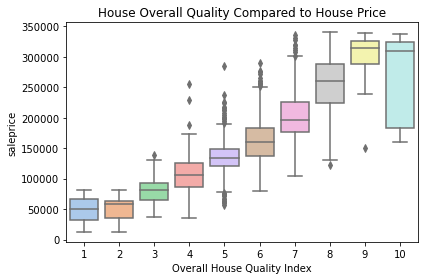

In [17]:
# Plot Overall Quality and Sale Price
sns.boxplot(x=house['overall_qual'], y=house['saleprice'],palette='pastel').set(title='House Overall Quality Compared to House Price')
plt.xlabel('Overall House Quality Index')
plt.tight_layout()
plt.savefig("Figures/box_overallquality.png")

In [18]:
# Drop outlier values
house = house.drop(house[(house['overall_qual']==9) & (house['saleprice']<200_000)] .index)
house = house.drop(house[(house['overall_qual']==4) & (house['saleprice']>200_000)] .index)
house = house.drop(house[(house['overall_qual']==5) & (house['saleprice']>200_000)] .index)
house = house.drop(house[(house['overall_qual']==10)].index)
house = house.drop(house[(house['overall_qual']==1)].index)

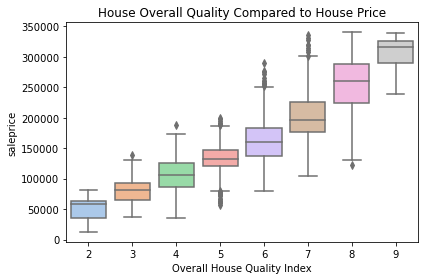

In [19]:
# Plot new Overall Quality and Sale Price
sns.boxplot(x=house['overall_qual'], y=house['saleprice'],palette='pastel').set(title='House Overall Quality Compared to House Price')
plt.xlabel('Overall House Quality Index')
plt.tight_layout()
plt.savefig("Figures/box_overallquality_outliers_removed.png")

In [20]:
# New correlation 'overall quality' and 'sale price'
house.corr()['overall_qual']['saleprice']

0.798793716665191

In [21]:
# Merge gr_liv_area with basement_area to get the total area of the house
house['area'] = (house['gr_liv_area'] + house['total_bsmt_sf'])
house.corr()['area']['saleprice']
# Correlation is higher than just ground level living area alone

0.7831272266850597

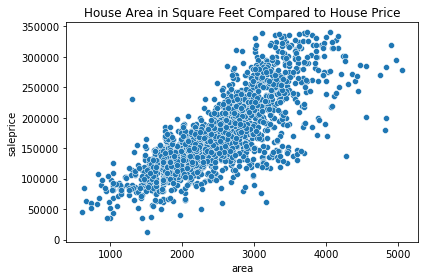

In [22]:
sns.scatterplot(x=house['area'], y=house['saleprice']).set(title='House Area in Square Feet Compared to House Price')
plt.tight_layout()
plt.savefig("Figures/scatter_area.png")

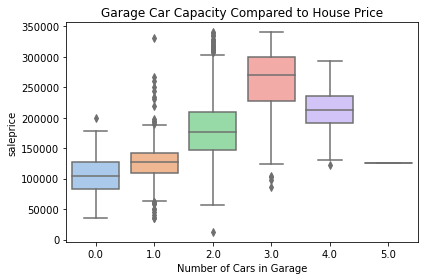

In [23]:
# Garage cars and Garage area are not independent of each other. Use only one
garage = sns.boxplot(x=house['garage_cars'], y=house['saleprice'], palette='pastel').set(title='Garage Car Capacity Compared to House Price')
plt.xlabel('Number of Cars in Garage')
plt.tight_layout()
plt.savefig("Figures/boxplot_garage_cars.png")

In [24]:
house['garage_cars'].value_counts()

2.0    1113
1.0     521
3.0     176
0.0     110
4.0      12
5.0       1
Name: garage_cars, dtype: int64

In [25]:
# Drop outliers for 'garage_cars'
house = house.drop(house[(house['garage_cars']==5)].index)
house = house.drop(house[(house['garage_cars']==1) & (house['saleprice']>300_000)] .index)
house = house.drop(house[(house['garage_cars']==2) & (house['saleprice']<50000)] .index)

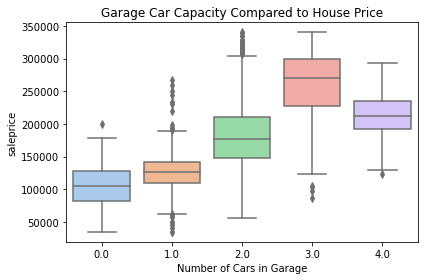

In [26]:
sns.boxplot(x=house['garage_cars'], y=house['saleprice'], palette='pastel').set(title='Garage Car Capacity Compared to House Price')
plt.xlabel('Number of Cars in Garage')
plt.tight_layout()
plt.savefig("Figures/boxplot_garage_cars_outliers_removed.png")

In [27]:
# Year built can be modified to age of the house
house['age'] = house['yr_sold'] - house['year_built']
house['age']

0        34
1        13
2        57
3         4
4       110
       ... 
2046      1
2047     69
2048     81
2049     53
2050     11
Name: age, Length: 1931, dtype: int64

In [28]:
# Does house['age'] display a higher correlation?
print(f"Age Correlation: {house.corr()['age']['saleprice']}")
print(f"Year built Correlation: {house.corr()['year_built']['saleprice']}")
print(f"Year sold Correlation: {house.corr()['yr_sold']['saleprice']}")

Age Correlation: -0.6094930112409103
Year built Correlation: 0.6100113328362282
Year sold Correlation: -0.0013259182393151893


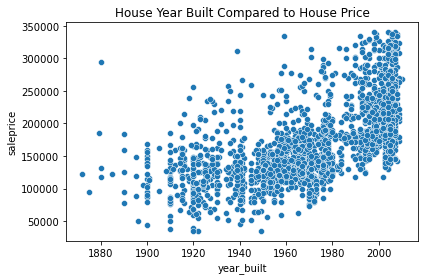

In [29]:
# Year built is slightly more correlated. 
sns.scatterplot(x=house['year_built'],y=house['saleprice']).set(title='House Year Built Compared to House Price')
plt.tight_layout()
plt.savefig("Figures/scatter_yrbuilt.png")

[Text(0.5, 1.0, 'House Age Compared to House Price')]

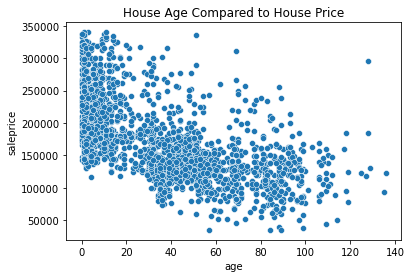

In [30]:
sns.scatterplot(x=house['age'], y=house['saleprice']).set(title='House Age Compared to House Price')

In [31]:
house['bathrooms'] = (house['bsmt_full_bath'] + house['full_bath'] + (0.5*house['bsmt_half_bath'] + (0.5*house['half_bath'])))

In [32]:
# Which feature display a higher correlation to sale price
print(f"Bathrooms Correlation: {house.corr()['bathrooms']['saleprice']}")
print(f"Fullbath Correlation: {house.corr()['full_bath']['saleprice']}")

Bathrooms Correlation: 0.6341609710707179
Fullbath Correlation: 0.5563420423759975


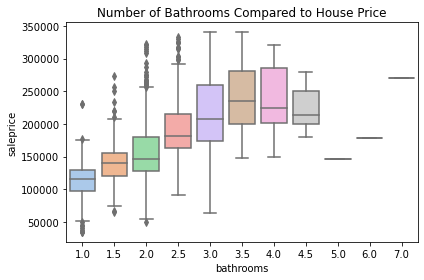

In [33]:
# New column 'bathrooms' has higher correlation to sale price. 
sns.boxplot(x=house['bathrooms'], y=house['saleprice'], palette='pastel').set(title='Number of Bathrooms Compared to House Price')
plt.tight_layout()
plt.savefig("Figures/boxplot_bathrooms.png")

In [34]:
house['bathrooms'].value_counts() # Determine what values can be dropped as outliers

2.0    628
2.5    372
1.0    311
3.0    248
1.5    191
3.5    153
4.0     17
4.5      5
6.0      2
7.0      2
5.0      1
Name: bathrooms, dtype: int64

In [35]:
# Drop outliers for 'bathrooms'
house = house.drop(house[(house['bathrooms']>=5)].index)
house = house.drop(house[(house['bathrooms']==1) & (house['saleprice']>200000)].index)

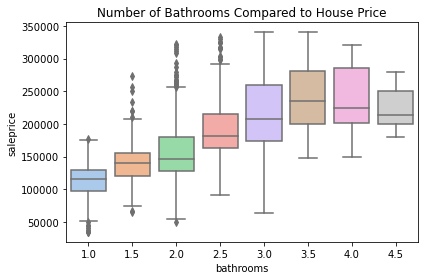

In [36]:
sns.boxplot(x=house['bathrooms'], y=house['saleprice'], palette='pastel').set(title='Number of Bathrooms Compared to House Price')
plt.tight_layout()
plt.savefig("Figures/boxplot_bathrooms_outliers_removed.png")

In [37]:
# Dummify Categorical columns to see the correlations
dum_house = pd.get_dummies(data=house, drop_first=True)

In [38]:
dum_house.corr()['saleprice'].sort_values()

exter_qual_TA       -0.620252
age                 -0.610995
kitchen_qual_TA     -0.558737
bsmt_qual_TA        -0.482271
garage_finish_Unf   -0.448561
                       ...   
bathrooms            0.650628
gr_liv_area          0.680667
area                 0.783887
overall_qual         0.799004
saleprice            1.000000
Name: saleprice, Length: 239, dtype: float64

In [39]:
#External Quality and Kitchen Quality has high correlation, change those values into numerical
house['exter_qual'].value_counts()

TA    1224
Gd     648
Ex      29
Fa      23
Name: exter_qual, dtype: int64

In [40]:
# Transform the quality description from string to number
house['exter_qual_int'] = house['exter_qual'].map({'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5})

In [41]:
# Correlation between saleprice and external quality
house.corr()['exter_qual_int']['saleprice']

0.6737086961677389

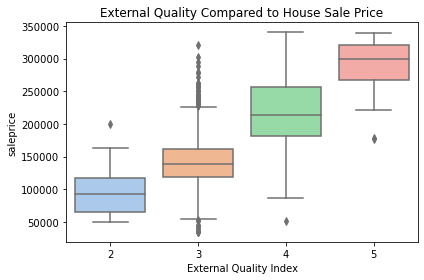

In [42]:
# plot external quality vs sale price
sns.boxplot(x=house['exter_qual_int'], y=house['saleprice'], palette='pastel').set(title='External Quality Compared to House Sale Price')
plt.xlabel('External Quality Index')
plt.tight_layout()
plt.savefig("Figures/boxplot_external.png")

In [43]:
# Remove Outliers
house = house.drop(house[(house['exter_qual_int']==2) & (house['saleprice']>190_000)].index)
house = house.drop(house[(house['exter_qual_int']==4) & (house['saleprice']<60000)].index)
house = house.drop(house[(house['exter_qual_int']==5) & (house['saleprice']<200_000)].index)

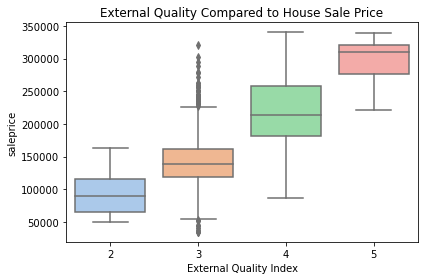

In [44]:
# New external quality vs sale price plot
sns.boxplot(x=house['exter_qual_int'], y=house['saleprice'], palette='pastel').set(title='External Quality Compared to House Sale Price')
plt.xlabel('External Quality Index')
plt.tight_layout()
plt.savefig("Figures/boxplot_external_outliers_removed.png")

In [45]:
# Transform the Kitchen quality description from string to number
print(house['kitchen_qual'].value_counts())

TA    1032
Gd     768
Ex      77
Fa      43
Name: kitchen_qual, dtype: int64


In [46]:
house['kitchen_qual_int'] = house['kitchen_qual'].map({'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5})
house.corr()['kitchen_qual_int']['saleprice']

0.6495219707837611

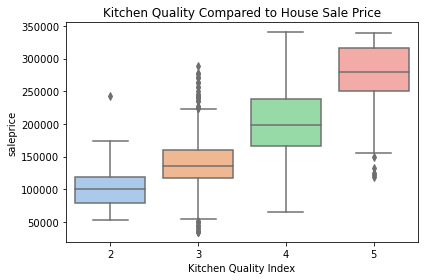

In [47]:
sns.boxplot(x=house['kitchen_qual_int'], y=house['saleprice'], palette='pastel').set(title='Kitchen Quality Compared to House Sale Price')
plt.xlabel('Kitchen Quality Index')
plt.tight_layout()
plt.savefig("Figures/boxplot_kitchen.png")

In [48]:
# Remove Outliers
house = house.drop(house[(house['kitchen_qual_int']==2) & (house['saleprice']>200_000)].index)

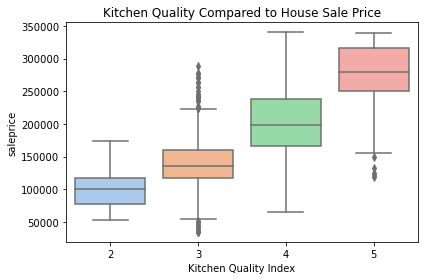

In [49]:
# Save the new plot
sns.boxplot(x=house['kitchen_qual_int'], y=house['saleprice'], palette='pastel').set(title='Kitchen Quality Compared to House Sale Price')
plt.xlabel('Kitchen Quality Index')
plt.tight_layout()
plt.savefig("Figures/boxplot_kitchen_outliers_removed.png")

# Modeling #

In [50]:
# Feature selection using some modified columns
features = ['overall_qual','area','garage_cars', 'year_built','bathrooms', 'kitchen_qual_int', 'exter_qual_int']
X = house[features]
y = house['saleprice']

In [51]:
# Statistic summary of the selected features.
X.describe()

,overall_qual,area,garage_cars,year_built,bathrooms,kitchen_qual_int,exter_qual_int
count,1919.000000,1918.000000,1918.000000,1919.000000,1918.000000,1919.000000,1919.000000
mean,5.992183,2463.422315,1.721585,1970.457009,2.159541,3.458572,3.353830
std,1.283342,666.716681,0.724893,29.911951,0.754462,0.610328,0.529007
min,2.000000,612.000000,0.000000,1872.000000,1.000000,2.000000,2.000000
25%,5.000000,1985.250000,1.000000,1953.000000,1.500000,3.000000,3.000000
50%,6.000000,2415.000000,2.000000,1972.000000,2.000000,3.000000,3.000000
75%,7.000000,2899.500000,2.000000,1999.000000,2.500000,4.000000,4.000000
max,9.000000,5048.000000,4.000000,2010.000000,4.500000,5.000000,5.000000


In [52]:
# Check for null values
X.isnull().sum()

overall_qual        0
area                1
garage_cars         1
year_built          0
bathrooms           1
kitchen_qual_int    0
exter_qual_int      0
dtype: int64

In [53]:
# Impute the null values with median
imp = SimpleImputer(strategy='median') # Instantiate simple imputer
imp_X = imp.fit_transform(X)
X = pd.DataFrame(imp_X, columns = X.columns)
X.isnull().sum() # Dataframe is free of missing values

overall_qual        0
area                0
garage_cars         0
year_built          0
bathrooms           0
kitchen_qual_int    0
exter_qual_int      0
dtype: int64

In [54]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [55]:
# Standard Scale the features
ss = StandardScaler() #Initiate standard scalar
ss.fit(X_train)
X_train_sc = ss.fit_transform(X_train) #Fit and transform the X_train
X_test_sc = ss.transform(X_test)  # Transform the X_test

In [56]:
# Fit the trainning set on a linear regression model
lr = LinearRegression() # Instantiate LinearRegression
lr.fit(X_train_sc, y_train) # Fit the linear regression on trainning data
print(f'Train score {lr.score(X_train_sc, y_train)}')
print(f'Test score {lr.score(X_test_sc, y_test)}')

Train score 0.8420541587075541
Test score 0.8302376989027375


In [57]:
# Polynomial features and R2
poly = PolynomialFeatures(include_bias=False) #Instantiate polynomial features
poly.fit(X_train_sc) # Fit the polynomial Transformation
#Transform the data
X_train_poly = poly.transform(X_train_sc)
X_test_poly = poly.transform(X_test_sc)
# View X_train_poly in a dataframe
pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X.columns)).head(5)

,overall_qual,area,garage_cars,year_built,bathrooms,kitchen_qual_int,exter_qual_int,overall_qual^2,overall_qual area,overall_qual garage_cars,...,year_built^2,year_built bathrooms,year_built kitchen_qual_int,year_built exter_qual_int,bathrooms^2,bathrooms kitchen_qual_int,bathrooms exter_qual_int,kitchen_qual_int^2,kitchen_qual_int exter_qual_int,exter_qual_int^2
0,1.553994,1.081901,1.764811,1.176392,-0.209794,0.872099,1.183482,2.414899,1.681269,2.742506,...,1.383897,-0.246800,1.025930,1.392238,0.044014,-0.182961,-0.248288,0.760556,1.032113,1.400629
1,-0.782324,-0.646999,0.378432,0.225991,-0.209794,-0.760427,-0.674028,0.612031,0.506163,-0.296056,...,0.051072,-0.047412,-0.171850,-0.152324,0.044014,0.159533,0.141407,0.578250,0.512549,0.454314
2,-0.782324,-0.729039,0.378432,-0.181324,-0.876531,-0.760427,1.183482,0.612031,0.570345,-0.296056,...,0.032878,0.158936,0.137883,-0.214593,0.768307,0.666538,-1.037359,0.578250,-0.899952,1.400629
3,0.775222,1.475386,-1.007947,-1.063838,-0.209794,-0.760427,-0.674028,0.600968,1.143751,-0.781382,...,1.131752,0.223187,0.808972,0.717057,0.044014,0.159533,0.141407,0.578250,0.512549,0.454314
4,-0.782324,-0.324920,0.378432,1.176392,-0.876531,-0.760427,-0.674028,0.612031,0.254192,-0.296056,...,1.383897,-1.031144,-0.894561,-0.792921,0.768307,0.666538,0.590807,0.578250,0.512549,0.454314


In [58]:
# Model the data using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
# Cross_validate using 10 folds and obtain R2 score
print(f"Polynomial train score: {cross_val_score(lr_poly, X_train_poly, y_train, cv=10).mean()}")
print(f"Polynomial test score: {cross_val_score(lr_poly, X_test_poly, y_test, cv=10).mean()}")

Polynomial train score: 0.8690429790938434
Polynomial test score: 0.8353717375339214


## Regularization ##

In [59]:
# Find the optimal alpha
r_alphas = np.logspace(0, 5, 100)
# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas = r_alphas, scoring='r2', cv=5)

# Fit linear regression model using best ridge alpha!
ridge_cv.fit(X_train_sc, y_train);
ridge_cv.alpha_

9.111627561154892

In [60]:
# Regularization with Ridge, on the linear reagression model and polynomial model
# Instantiate
ridge_model = Ridge(alpha=9)
#Fit on the linear model
ridge_model.fit(X_train_sc, y_train)
# Evaluate model using R2.
print(f"Ridge Train score: {ridge_model.score(X_train_sc, y_train)}")
print(f"Ridge Test score: {ridge_model.score(X_test_sc, y_test)}")

Ridge Train score: 0.8420479578060757
Ridge Test score: 0.8301949897134427


In [61]:
# Fit linear regression with polynomial features model using best ridge alpha!
# Find the optimal alpha
r_alphas_poly = np.logspace(0, 5, 100)
# Cross-validate over our list of ridge alphas.
ridge_cv_poly = RidgeCV(alphas = r_alphas_poly, scoring='r2', cv=5)

ridge_cv_poly.fit(X_train_poly, y_train);
ridge_cv_poly.alpha_

41.32012400115337

In [62]:
# Ridge model fit on the polynomial model
# Instantiate
ridge_model_poly = Ridge(alpha=41)
#Fit on the linear model
ridge_model_poly.fit(X_train_poly, y_train)
# Evaluate model using R2.
print(f"Ridge Poly Train score: {ridge_model_poly.score(X_train_poly, y_train)}")
print(f"Ridge Poly Test score: {ridge_model_poly.score(X_test_poly, y_test)}")

Ridge Poly Train score: 0.8769481699034806
Ridge Poly Test score: 0.8567373796275002


In [63]:
# Instanitiate LASSO regularization
lasso_cv = LassoCV()
# Fit lasso regularization on linear regression model
lasso_cv.fit(X_train_sc, y_train)
# Evaluate the model after lasso regularization
print(f"Lasso Train score: {lasso_cv.score(X_train_sc, y_train)}")
print(f"Lasso Test score: {lasso_cv.score(X_test_sc, y_test)}")

Lasso Train score: 0.8420530927235461
Lasso Test score: 0.8302743828419792


In [64]:
# Instanitiate LASSO regularization
lasso_cv_poly = LassoCV()
# Fit lasso regularization on linear regression model with polynomial features
lasso_cv_poly.fit(X_train_poly, y_train)
# Evaluate the model after lasso regularization
print(f"Lasso Poly Train score: {lasso_cv_poly.score(X_train_poly, y_train)}")
print(f"Lasso Poly Test score: {lasso_cv_poly.score(X_test_poly, y_test)}")

Lasso Poly Train score: 0.8765086398435354
Lasso Poly Test score: 0.8564088137904288


# Evaluation: Which model to be selected for prediction? #

In [65]:
print(f'Train score {lr.score(X_train_sc, y_train)}')
print(f'Test score {lr.score(X_test_sc, y_test)}')
diff = lr.score(X_train_sc, y_train) - lr.score(X_test_sc, y_test)
print('Difference:', diff) 
print()
print(f"Polynomial train score: {cross_val_score(lr_poly, X_train_poly, y_train, cv=10).mean()}")
print(f"Polynomial test score: {cross_val_score(lr_poly, X_test_poly, y_test, cv=10).mean()}")
diff_poly = cross_val_score(lr_poly, X_train_poly, y_train, cv=10).mean() - cross_val_score(lr_poly, X_test_poly, y_test, cv=10).mean()
print('Difference:', diff_poly)
print()
print(f"Ridge Train score: {ridge_model.score(X_train_sc, y_train)}")
print(f"Ridge Test score: {ridge_model.score(X_test_sc, y_test)}")
diff_ridge = ridge_model.score(X_train_sc, y_train) - ridge_model.score(X_test_sc, y_test)
print('Difference:', diff_ridge)
print()
print(f"Ridge Poly Train score: {ridge_model_poly.score(X_train_poly, y_train)}")
print(f"Ridge Poly Test score: {ridge_model_poly.score(X_test_poly, y_test)}")
diff_ridgepoly = ridge_model_poly.score(X_train_poly, y_train) - ridge_model_poly.score(X_test_poly, y_test)
print('Difference::', diff_ridgepoly)
print()
print(f"Lasso Train score: {lasso_cv.score(X_train_sc, y_train)}")
print(f"Lasso Test score: {lasso_cv.score(X_test_sc, y_test)}")
diff_lasso = lasso_cv.score(X_train_sc, y_train) - lasso_cv.score(X_test_sc, y_test)
print(diff_lasso)
print()
print(f"Lasso Poly Train score: {lasso_cv_poly.score(X_train_poly, y_train)}")
print(f"Lasso Poly Test score: {lasso_cv_poly.score(X_test_poly, y_test)}")
diff_lassopoly = lasso_cv_poly.score(X_train_poly, y_train) - lasso_cv_poly.score(X_test_poly, y_test)
print(diff_lassopoly)
print()

Train score 0.8420541587075541
Test score 0.8302376989027375
Difference: 0.011816459804816604

Polynomial train score: 0.8690429790938434
Polynomial test score: 0.8353717375339214
Difference: 0.03367124155992207

Ridge Train score: 0.8420479578060757
Ridge Test score: 0.8301949897134427
Difference: 0.01185296809263292

Ridge Poly Train score: 0.8769481699034806
Ridge Poly Test score: 0.8567373796275002
Difference:: 0.020210790275980384

Lasso Train score: 0.8420530927235461
Lasso Test score: 0.8302743828419792
0.011778709881566929

Lasso Poly Train score: 0.8765086398435354
Lasso Poly Test score: 0.8564088137904288
0.020099826053106673



- Linear Regression model after Lasso regularization has high R2 scores for both the train and the test. It also has the smallest differnce between train score and test score among all the models created. It should perform the best at generalizing the test dataset. 
- Thus, linear regression model after Lasso regularization will be selected for the prediction of house prices.

# Prediction #

In [66]:
# Load test dataset
test = pd.read_csv('Original data/test.csv')
# Convert test data columns to be the same as the data that we trained on.
test.columns = [column.replace(' ', '_').lower() for column in test.columns]

In [67]:
# Recall the features used for prediction
X.columns

Index(['overall_qual', 'area', 'garage_cars', 'year_built', 'bathrooms',
       'kitchen_qual_int', 'exter_qual_int'],
      dtype='object')

In [68]:
# Edit the columns in test dataset to match the train data set
test['bathrooms'] = (test['bsmt_full_bath']+ (0.5*test['bsmt_half_bath'])+ test['full_bath'] + (0.5*test['half_bath']))
test['kitchen_qual_int'] = test['kitchen_qual'].map({'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5})
test['exter_qual_int'] = test['exter_qual'].map({'Po': 1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5})

In [69]:
# Readdress the features that's used in model
features = ['overall_qual', 'gr_liv_area', 'garage_cars', 'year_built', 'bathrooms',
       'kitchen_qual_int', 'exter_qual_int']

In [70]:
# Set the X variables for test dataset
test_X = test[features]
# Transform the test columns to standard scalar
test_X_sc = ss.transform(test_X)

In [71]:
# Fit test data to lasso linear regression model
predictions = lasso_cv.predict(test_X_sc)

In [72]:
# Assigning to dataframe
test['saleprice'] = predictions
test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,bathrooms,kitchen_qual_int,exter_qual_int,saleprice
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,NaN,NaN,0,4,2006,WD,2.0,2,3,113329.874168
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,8,2006,WD,2.0,3,3,134313.567210
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,9,2006,New,3.5,4,4,181178.775098
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,7,2007,WD,1.0,3,4,93281.783237
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,7,2009,WD,2.5,3,3,128933.458078


In [73]:
#Save Predictions for Kaggle Submission
test[['id','saleprice']].to_csv('Modified data/kaggle_sub_3.csv', index=False)

## Evaluation ##
- The linear regression model with lasso regularization will be used to predict sale prices. 
- The difference between the training score and testing score is the smallest among all the models. There is a balance between bias/variance. The model is not over nor under fit. 
- The model test R2 score is 0.83, meaning that 83% of the variability in the target sale price can be explained by the linear regression model with lasso regularization.
- The difference between the trainning R2 score and testing R2 score is 0.01. There is a balance between bias-variance tradeoff. The model is not over nor under fit. 

In [74]:
# Lasso Model coefficient
lasso_cv.coef_

array([15070.09479427, 22414.68887529,  7030.25805526,  4390.99087869,
        6723.65512739,  7141.88771696,  5384.46953532])

In [75]:
# Lasso Model intercept
lasso_cv.intercept_

169990.35244299675

In [76]:
# Zip coefficients and column names together
set(zip(X_train.columns, lr.coef_))

{('area', 22432.06149704184),
 ('bathrooms', 6735.716802158775),
 ('exter_qual_int', 5395.322215391367),
 ('garage_cars', 7047.092464136122),
 ('kitchen_qual_int', 7154.932050900522),
 ('overall_qual', 15068.629876198636),
 ('year_built', 4402.030179655748)}

### Interpretations ###
- Holding all else constant, for every year built of the house, we expect a \\$4402 increase in the sale price.
- Holding all else constant, for every level increase in the external quality of the house, we expect about \\$5395 more increase in sale price. 
- Holding all else constant, we expect about \\$6735 more increase in the sale price for every additional bathrooms in the house.
-  Holding all else constant, we expect about \\$7047 more increase in the sale price for every car parking space in the garage. 
- Holding all else constant, we expect about \\$7154 increase in the sale price for every quality level increase in the kitchen quality.
- Holding all else constant, for every quality level of increase in the house's overall quality, we expect a \\$15068 increase in the sale price.
- Holding all else constant, for every one square feet increase in the house area, we expect about \\$22432 more increase in sale price. 